# Trading the electricity market

The challenge is to come up with some data analysis or modelling that might be of interest to someone trying to trade. \
My idea: let's build a trading-bot that automatically trades the energy market.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader


# load order book data
#ob = pd.read_csv("data/order-books-20190521-20190524-local.tsv", sep="\t", parse_dates=["timestamp", "delivery_start", "delivery_end"])

# load trade data
tr = pd.read_csv("data/trade-20190521-20190524-local.tsv", sep="\t", parse_dates=["execution_time", "delivery_start", "delivery_end"])

Note: I didnt use the orderbook data due to time constraints and because minimal required information is in the trading dataset

In [2]:
#let look at some data
print(tr.shape)
print(tr.isna().any().any())
tr.sample(3)

(70852, 12)
False


,line_number,idx,execution_time,qty,px,product,contract_id,buy_delivery_area_id,sell_delivery_area_id,long_name,delivery_start,delivery_end
38436,59444,124378,2019-05-23T04:17:50.594Z,5000,5300,Intraday_Power_D,11256967,10YDE-EON------1,10YDE-ENBW-----N,20190523 07:00-20190523 08:00,2019-05-23 05:00:00+00:00,2019-05-23 06:00:00+00:00
39218,60968,127355,2019-05-23T05:11:02.223Z,1300,5299,Quarterly_Hour_Power,11256973,10YDE-RWENET---I,10YDE-EON------1,20190523 07:45-20190523 08:00,2019-05-23 05:45:00+00:00,2019-05-23 06:00:00+00:00
65585,103452,213403,2019-05-24T05:36:30.082Z,5000,2000,Quarterly_Hour_Power,11258158,10YDE-RWENET---I,10YDE-RWENET---I,20190524 07:45-20190524 08:00,2019-05-24 05:45:00+00:00,2019-05-24 06:00:00+00:00


In [3]:
# change some dtypes:
tr['execution_time'] = pd.to_datetime(tr['execution_time'], utc=True, format='mixed')

Create train, val, test datasets

In [4]:
tr.sort_values(by='execution_time', inplace=True)

# Define the proportions for train, validation, and test sets
train_ratio = 0.75  # 70% for training
val_ratio = 0.15  # 15% for validation
test_ratio = 0.10  # 10% for testing

# Calculate the lengths of each set
total_length = len(tr)
train_length = int(total_length * train_ratio)
val_length = int(total_length * val_ratio)

# Split the DataFrame into train, validation, and test sets
train_df = tr.iloc[:train_length]
val_df = tr.iloc[train_length:train_length + val_length]
test_df = tr.iloc[train_length + val_length:]

Data preperation

In [5]:
def dataprep(df):
    df = df.reset_index(drop=True)
    df['id'] = df['contract_id'].astype(str)+df['product']+ df['buy_delivery_area_id']+df['sell_delivery_area_id']+df['delivery_start'].astype(str)

    # clean
    df = df.loc[(df['px']>0)]
    df['px'].fillna(method='ffill', inplace=True)
    
    # create some basic features
    df['execution_time_h'] = df['execution_time'].dt.hour
    df['execution_time_dow'] = df['execution_time'].dt.dayofweek
    df['delivery_start_h'] = df['delivery_start'].dt.hour
    df['delivery_start_dow'] = df['delivery_start'].dt.dayofweek
    
    # create one hot encodings fo cat variables
    oh = pd.get_dummies(df['product'], prefix='prod_')
    df = pd.concat([df, oh], axis=1)
    oh = pd.get_dummies(df['buy_delivery_area_id'], prefix='buy_')
    df = pd.concat([df, oh], axis=1)
    oh = pd.get_dummies(df['sell_delivery_area_id'], prefix='sell_')
    df = pd.concat([df, oh], axis=1)

    # calculate price change
    df.sort_values(by=['execution_time','id'], inplace=True)
    df = df.reset_index(drop=True)
    df['dpx'] = df['px'].pct_change()
    df['dpx_1'] = df['dpx'].shift(1) #include a lag for momentum trading
    df.fillna(0, inplace=True)

    # Delete the first row for each product, because the price change is not correct (quickfix)
    df = df.groupby(['id']).apply(lambda x: x.iloc[1:]).reset_index(drop=True)
    
    # remove price outliers
    df = df[(df['dpx'] >= -1) & (df['dpx'] <= 1)]
    std_value = df['dpx'].std()
    threshold = 2 * std_value
    df = df[(df['dpx'] >= -threshold) & (df['dpx'] <= threshold)]
    
    #normalize:
    input_cols = ['dpx_1', 'execution_time_h', 'execution_time_dow', 'delivery_start_h', 'delivery_start_dow', 'prod__Intraday_Power_D', 'prod__Quarterly_Hour_Power', 'buy__10YDE-ENBW-----N', 'buy__10YDE-EON------1', 'buy__10YDE-RWENET---I', 'buy__10YDE-VE-------2', 'sell__10YDE-ENBW-----N', 'sell__10YDE-EON------1', 'sell__10YDE-RWENET---I', 'sell__10YDE-VE-------2']
    mins = [-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    maxs = [1,23,6,23,6,1,1,1,1,1,1,1,1,1,1,1]
    
    for idx, c in enumerate(input_cols):
        df[c] = (df[c] - mins[idx]) / (maxs[idx] - mins[idx])
    
    #create tensors
    features = torch.tensor(df[input_cols].values, dtype=torch.float32)
    target = torch.tensor(df['dpx'].values, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for the output
    
    return df, features, target, input_cols

train_df, train_features, train_target, input_cols = dataprep(train_df)
val_df, val_features, val_target, _ = dataprep(val_df)
test_df, test_features, test_target, _ = dataprep(test_df)

Let's look at the data

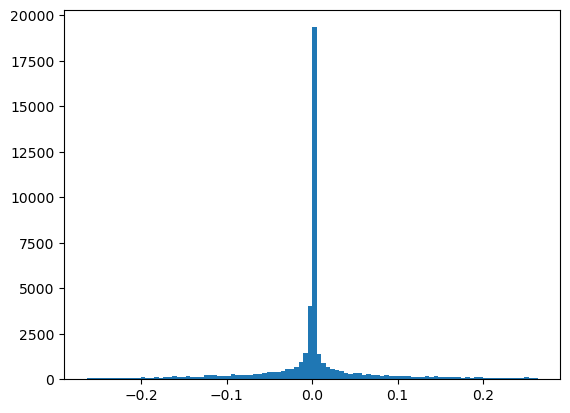

In [6]:
#plot histograms of price changes
plt.hist(train_df['dpx'], bins=100);

Let's train a neural network to predict the price changes

In [7]:
# Define dataset
class Dataset(Dataset):
    def __init__(self):
        self.data = train_features
        self.targets = train_target

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

dataset = Dataset()

# Create a DataLoader
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Define a simple neural network model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(len(input_cols), 64)  # 3 input features, 64 hidden units
        self.fc2 = nn.Linear(64, 1)  # 1 output (target) variable
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        return x

# Instantiate the model and define loss function and optimizer
model = Model()
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=3e-4)  # Adam optimizer 

# Early stopping parameters
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement to wait
early_stopping_counter = 0

# Training loop
epochs = 10000
for epoch in range(epochs):
    for batch_inputs, batch_targets in dataloader:
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_inputs)

        # Calculate loss
        loss = criterion(predictions, batch_targets)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()
    
    # Calculate validation loss
    with torch.no_grad():
        val_predictions = model(val_features)
        val_loss = criterion(val_predictions, val_target)

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
        
    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch [1/10000], Training Loss: 0.0035, Validation Loss: 0.0064
Epoch [2/10000], Training Loss: 0.0071, Validation Loss: 0.0063
Epoch [3/10000], Training Loss: 0.0080, Validation Loss: 0.0063
Epoch [4/10000], Training Loss: 0.0044, Validation Loss: 0.0063
Epoch [5/10000], Training Loss: 0.0061, Validation Loss: 0.0063
Epoch [6/10000], Training Loss: 0.0067, Validation Loss: 0.0063
Epoch [7/10000], Training Loss: 0.0067, Validation Loss: 0.0063
Epoch [8/10000], Training Loss: 0.0361, Validation Loss: 0.0063
Epoch [9/10000], Training Loss: 0.0064, Validation Loss: 0.0063
Epoch [10/10000], Training Loss: 0.0029, Validation Loss: 0.0063
Epoch [11/10000], Training Loss: 0.0029, Validation Loss: 0.0063
Epoch [12/10000], Training Loss: 0.0057, Validation Loss: 0.0064
Epoch [13/10000], Training Loss: 0.0072, Validation Loss: 0.0063
Epoch [14/10000], Training Loss: 0.0054, Validation Loss: 0.0062
Epoch [15/10000], Training Loss: 0.0046, Validation Loss: 0.0063
Epoch [16/10000], Training Loss: 0

In [9]:
# use model on unseen test set
with torch.no_grad():
    test_predictions = model(test_features)
    test_loss = criterion(test_predictions, test_target)
print(f'Test Loss:  {test_loss.item():.4f}')

Test Loss:  0.0047


Making some plots of the predictions

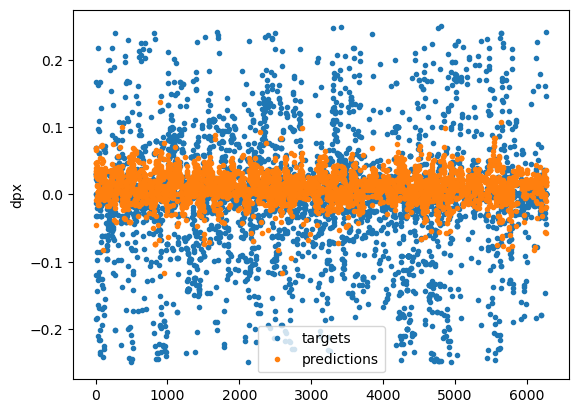

In [10]:
# predicted prices changes
plt.plot(test_target.squeeze(1).tolist(), label='targets', marker='.', linestyle='')
plt.plot(test_predictions.squeeze(1).tolist(), label='predictions', marker='.', linestyle='')
plt.ylabel('dpx')
plt.legend()
plt.show()

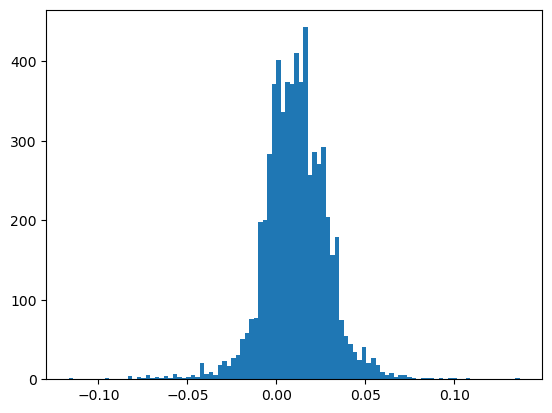

In [11]:
#hist of price changes
plt.hist(test_predictions.squeeze(1).tolist(), bins=100);

In [12]:
# calculate returns from model predictions
rl=sum(test_target[test_predictions>0])
rs=-sum(test_target[test_predictions<0])
print(f'Return from long positions:  {rl*100}%')
print(f'Return from short positions:  {rs*100}%')
print(f'Total return:  {(rl+rs)*100}%')

Return from long positions:  1853.0697021484375%
Return from short positions:  3291.135009765625%
Total return:  5144.20458984375%


A trader that would use the model to trade, would hypothetically make a profit. However, this result is not realistic. For example, bid/ask spreads and broker fees are not taken into account. The model can change positions within seconds, which can lead to a large number of trades (and high costs).

In [13]:
# save the model
torch.save(model.state_dict(), 'models/model.pth')

In the file trading_bot.py, I've put all things together (model and some buy/sell logic). One can run this script on a server/pc and let it automatically trade. For example:

In [14]:
from trading_bot import trading_bot
import random, time

for t in range(20): #Running trading-bot for 20 seconds"
    random_values = [random.uniform(0, 1) for _ in range(15)] #random input data
    trade = trading_bot(random_values)
    print(trade)
    time.sleep(1)

Sell!
Buy!
Hold
Buy!
Sell!
Hold
Buy!
Buy!
Buy!
Hold
Buy!
Hold
Buy!
Sell!
Buy!
Buy!
Buy!
Buy!
Buy!
Buy!


#### Improvements
-work with bid/ask prices for trading (more realistic)\
-get more (proprietary) data \
-try different and better models/architectures. I left this as TODO, as the goal of this challenge not to find a solution to a specific problem \
-try more complex trading strategy. Idea; using the model for a net-zero strategy where several products are traded at the same time, short/long positions netting 0

#### Discussion
-The above solution is very simplistic and not usable for a trader, but showes my experience with basic ML and data science concepts \
-For a market where this type of clean data is available to everyone, one can assume a perfect market. A trading strategy like implemented above, would not work.\
-Besides speculation, companies are trading the energy market for portfolio diversification, risk management, procurement or resource optimization. Interesting directions to consider.